<a href="https://colab.research.google.com/github/AnnLivio/runkeeper_data_analysis/blob/main/running_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Don't stop me now 🏃 🚴 🚶

En esta segunda parte, continuamos con las transformaciones necesarias de los datos para obtener las primeras visualizaciones y posteriormente construir nuestro modelo de Prophet para obtener predicciones sobre nuestra serie de tiempo.

## Importación de librerías y carga de datos

In [2]:
# Import libraries
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") # do not distube mode

# Predictions
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Load the clean data
path = '/content/drive/MyDrive/Data Analysis/01_runkeeper_data/'
df = pd.read_csv(path+'runkeeper_cleandata.csv')

## Tranformaciones a priori

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  287 non-null    object 
 1   Type                  287 non-null    object 
 2   Distance (km)         287 non-null    float64
 3   Duration              287 non-null    object 
 4   Average Pace          287 non-null    float64
 5   Average Speed (km/h)  287 non-null    float64
 6   Calories Burned       287 non-null    float64
 7   Climb (m)             287 non-null    int64  
 8    Steps                285 non-null    float64
 9   Month                 287 non-null    int64  
 10  WeekDay               287 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 24.8+ KB


In [4]:
# Convert Date in datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Replace trail running with running
df['Type'] = df['Type'].replace({'Trail Running':'Running'})

# Replace the other activities with Other
df.loc[df['Type'].isin(('Mountain Biking','Walking','Cycling')), 'Type'] = 'Other'

In [6]:
# Rename columns
df.rename(columns={'Average Speed (km/h)':'Avg_speed','Distance (km)':'Distance', 'Climb (m)':'Climb', ' Steps':'Steps'}, inplace=True)

In [7]:
# Drop unnecessary columns
df.drop(columns=['Average Pace','Calories Burned'], inplace=True)

In [8]:
df.Type.value_counts()

,count
Type,
Running,273
Other,14


In [9]:
# Extract only running activities
running = df.query('Type == "Running"')

In [126]:
running.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 0 to 286
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       273 non-null    datetime64[ns]
 1   Type       273 non-null    object        
 2   Distance   273 non-null    float64       
 3   Duration   273 non-null    object        
 4   Avg_speed  273 non-null    float64       
 5   Climb      273 non-null    int64         
 6   Steps      272 non-null    float64       
 7   Month      273 non-null    int64         
 8   WeekDay    273 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 21.3+ KB


In [127]:
running.describe()

,Date,Distance,Avg_speed,Climb,Steps,Month,WeekDay
count,273,273.000000,273.000000,273.000000,272.000000,273.000000,273.000000
mean,2024-02-12 06:30:16.139194112,7.352601,10.141026,62.523810,7155.080882,6.820513,2.798535
min,2023-06-28 09:25:17,5.070000,7.320000,23.000000,4.000000,1.000000,0.000000
25%,2023-10-10 18:16:24,6.190000,9.740000,45.000000,6257.750000,4.000000,1.000000
50%,2024-02-12 17:55:11,6.720000,10.330000,54.000000,6987.500000,8.000000,3.000000
75%,2024-05-15 17:27:52,8.080000,10.710000,67.000000,7937.250000,9.000000,4.000000
max,2024-11-20 15:57:36,15.910000,11.550000,220.000000,16729.000000,12.000000,6.000000
std,NaN,1.608718,0.798027,29.857018,2225.156818,3.246154,1.966558


**Observaciones**
+ El mínimo en `Steps` es claramente un error a observar y corregir si corresponde.
+ Necesitamos convertir la columna Duration a float

## Tranformaciones
+ Primero extraemos los datos del primer año puesto que el total corresponde a año y medio aproximadamente.
+ Convertir `Duration` a número flotante.
+ Corrección de errores e imputaciones necesarias.
+ Generación de columnas necesarias.

In [10]:
# Select a year data from july 2023 to june 2024
data = running.query('"2023-07-01" <= Date < "2024-07-01"')

In [11]:
# Convert Duration to float
data['Duration'] = round(data['Duration'] / np.timedelta64(1,'m'),2)

In [12]:
# Checking erros in Steps
data.query('Steps < 1000')

,Date,Type,Distance,Duration,Avg_speed,Climb,Steps,Month,WeekDay
85,2024-05-10 18:33:06,Running,6.19,36.55,10.15,36,8.0,5,4
117,2024-03-27 11:03:13,Running,6.43,37.73,10.22,41,27.0,3,2
130,2024-03-10 15:02:58,Running,6.31,35.55,10.65,42,8.0,3,6
141,2024-02-23 15:46:46,Running,6.12,34.77,10.57,34,18.0,2,4
155,2024-02-03 16:32:31,Running,6.23,34.88,10.72,38,18.0,2,5
165,2024-01-22 16:03:15,Running,7.53,41.53,10.87,51,6.0,1,0
175,2023-12-24 09:46:08,Running,10.08,61.58,9.82,207,9.0,12,6
212,2023-10-17 17:28:08,Running,6.10,35.48,10.31,43,4.0,10,1
240,2023-09-07 15:52:28,Running,6.09,36.42,10.04,59,4.0,9,3


In [13]:
# Impute error in Steps
data.loc[data['Steps'] < 100, 'Steps'] = data['Steps'].median()

In [135]:
def activity_intensifier(activity):
  """
    Return 1 if the activity is High
    Return 0 if the activity is Low or Medium

  """
  if (activity['Duration'] >= 55) and (activity['Avg_speed'] >= 10):
    val = 1
  else:
    val = 0
  return val

In [136]:
# Apply the `activity_intensifier()` function to the new column Intensity
# where 1 = high intensity, 0 = low/med intensity

data['Intensity'] = data.apply(activity_intensifier, axis=1)

In [137]:
# Create column weekend / WeekDay starts with Monday = 0 and ends with Sunday = 6
data['Weekend'] = 0
data.loc[data['WeekDay'] >= 5, 'Weekend'] = 1


In [138]:
data.tail(3)

,Date,Type,Distance,Duration,Avg_speed,Climb,Steps,Month,WeekDay,Intensity,Weekend
282,2023-07-06 09:44:29,Running,6.09,45.98,7.95,98,7902.0,7,3,0,0
283,2023-07-04 10:19:56,Running,6.03,46.53,7.78,100,7780.0,7,1,0,0
284,2023-07-02 09:13:52,Running,5.69,45.13,7.57,122,7385.0,7,6,0,1


In [14]:
#Create list of weekday in order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a dict of Month in order
month_order = ['July', 'August', 'September', 'October', 'November', 'December','January', 'February', 'March', 'April', 'May', 'June']

# Análisis exploratorio y visualizaciones
### Detectando outliers

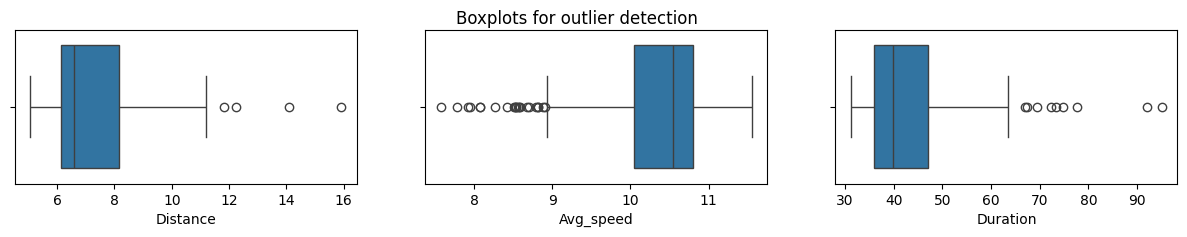

In [36]:
# Box plot for distance, Average_speed and duration
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=data['Distance'])
sns.boxplot(ax=axes[1], x=data['Avg_speed'])
sns.boxplot(ax=axes[2], x=data['Duration'])
plt.show();

In [140]:
data.describe()

,Date,Distance,Duration,Avg_speed,Climb,Steps,Month,WeekDay,Intensity,Weekend
count,215,215.000000,215.000000,215.000000,215.000000,214.000000,215.000000,215.000000,215.000000,215.000000
mean,2023-12-21 03:03:30.288371968,7.398000,43.498093,10.244326,62.386047,7343.257009,6.293023,2.781395,0.120930,0.232558
min,2023-07-02 09:13:52,5.070000,31.200000,7.570000,23.000000,2382.000000,1.000000,0.000000,0.000000,0.000000
25%,2023-09-25 06:42:28.500000,6.120000,35.965000,10.040000,46.000000,6232.750000,3.000000,1.000000,0.000000,0.000000
50%,2023-12-16 10:52:17,6.580000,39.780000,10.540000,55.000000,6798.500000,7.000000,3.000000,0.000000,0.000000
75%,2024-03-20 04:45:14.500000,8.155000,47.065000,10.795000,69.000000,7919.250000,9.000000,4.000000,0.000000,0.000000
max,2024-06-22 19:31:10,15.910000,95.080000,11.550000,220.000000,16729.000000,12.000000,6.000000,1.000000,1.000000
std,NaN,1.748853,10.582849,0.817548,29.116825,1961.081469,3.403228,1.970253,0.326807,0.423449


## Actividades en la semana vs fines de semana

In [141]:
# 0 is for weekdays, 1 for weekend
data['Weekend'].value_counts(normalize=True).round(4)*100

,proportion
Weekend,
0,76.74
1,23.26


Teniendo en cuenta que el fin de semana corresponde al 28% del total de la semana, un 23% de actividades indica leve descenso de actividades en esos días.

## Carreras de intensidad alta vs baja/media

In [143]:
# 0 for low/med and 1 for high
data['Intensity'].value_counts(normalize=True).round(4)*100

,proportion
Intensity,
0,87.91
1,12.09


## Visualizaciones por mes y día de la semana

In [15]:
# Total distance per day and Avg_speed
per_day = data.groupby('WeekDay').agg({'Distance':'sum', 'Avg_speed':'mean', 'Climb':'sum'})
per_day.index = weekday_order
per_day.round(2)

,Distance,Avg_speed,Climb
Monday,284.99,10.29,2484
Tuesday,238.76,10.29,1954
Wednesday,190.44,10.28,1513
Thursday,221.46,10.16,1811
Friday,266.31,10.26,2270
Saturday,205.94,10.36,1688
Sunday,182.67,10.01,1693


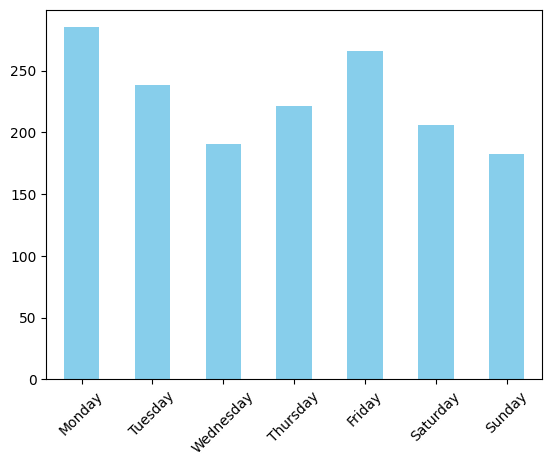

In [35]:
per_day['Distance'].plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Total distance per day and Avg_speed
per_month = data.groupby('Month').agg({'Distance':'sum', 'Avg_speed':'mean', 'Climb':'sum'}).reindex([7,8,9,10,11,12,1,2,3,4,5,6])
per_month.index = month_order
per_month.round(2)

,Distance,Avg_speed,Climb
July,110.60,8.47,1270
August,148.14,9.12,1304
September,134.43,9.77,1575
October,161.88,10.37,1268
November,152.70,10.53,1170
December,102.46,10.64,1009
January,143.92,10.70,1199
February,160.24,10.73,1244
March,146.19,10.81,1112
April,160.08,10.97,1054


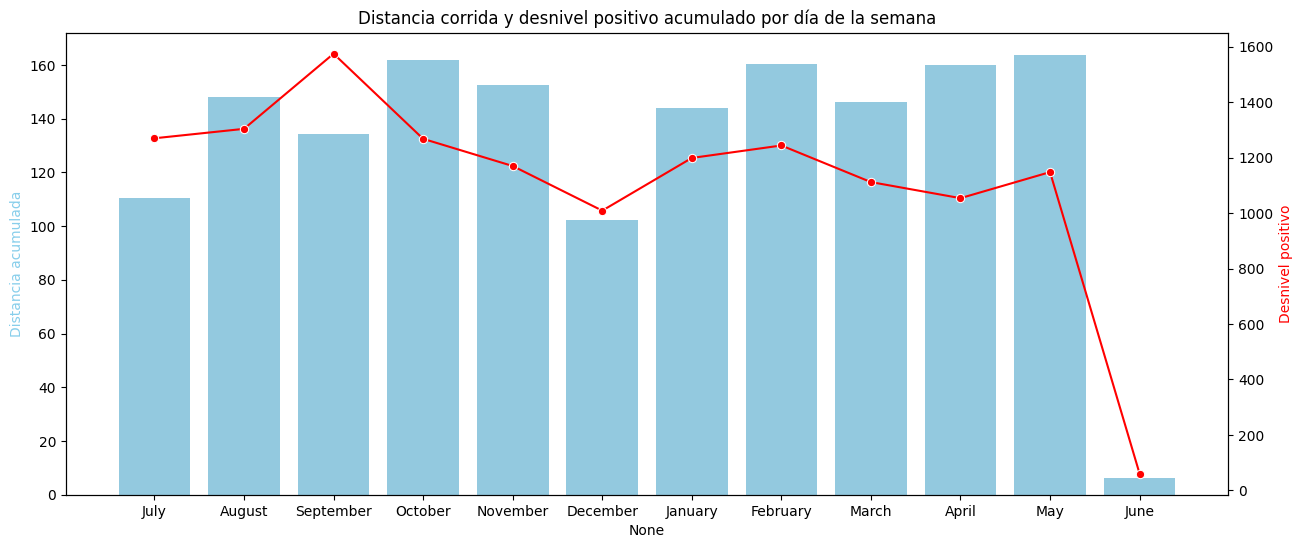

In [20]:
# Creaate the bar graph
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = sns.barplot(x=per_month.index, y=per_month['Distance'], color='skyblue')
ax1.set_ylabel('Distancia acumulada', color='skyblue')

# Crear line chart
ax2 = ax1.twinx()
ax2 = sns.lineplot(x=per_month.index, y=per_month['Climb'], color='red', marker='o')
ax2.set_ylabel('Desnivel positivo', color='red')

# Set tittle and show the graphic
plt.title('Distancia corrida y desnivel positivo acumulado por día de la semana')
plt.show()

In [187]:
# Create correlation matrix using pearson correlation coefficient
duration_data = data.groupby(['Month', 'Day']).agg({'Duration':'sum'})
duration_data.unstack().style.background_gradient(cmap='Greens_r')

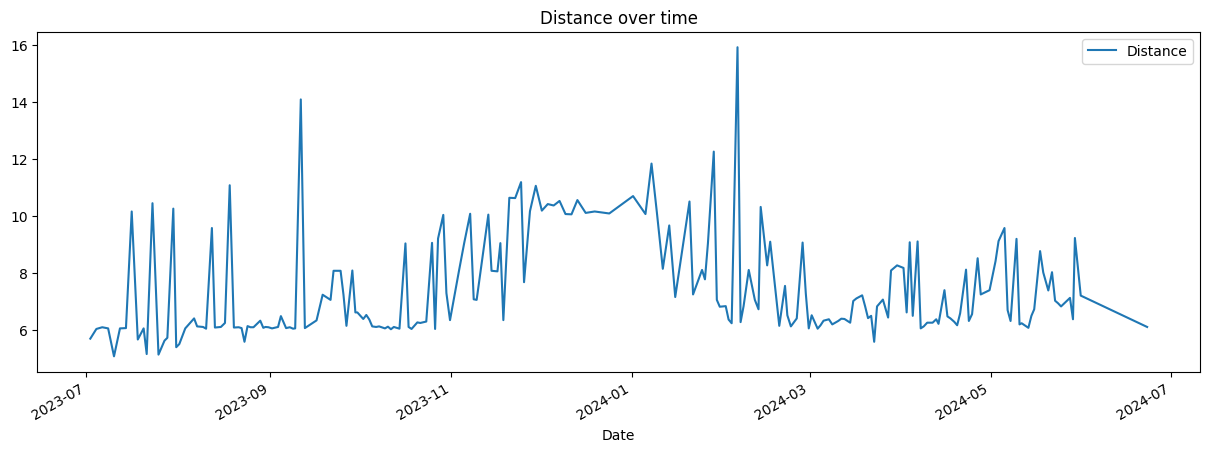

In [175]:
data.plot(x='Date', y='Distance', figsize=(15,5), title='Distance over time');

## Export First Year Data

In [146]:
# Export data for visualizations in Looker Studio
data.to_csv(path + 'running_202307202406.csv', index=False)

# Predictions with Prophet

In [160]:
# Create weekly data set
# Set Date as index
weekly_df = data.copy().set_index('Date')

# Group data per week of the year
weekly_df = weekly_df['Distance'].resample('W').sum()

In [161]:
# Reset index
weekly_df = weekly_df.reset_index()

# Rename Date and Distance for Prophet
weekly_df.rename(columns={'Date':'ds', 'Distance':'y'}, inplace=True)

In [162]:
# Drop the first and last weeks, they're incomplete
weekly_df = weekly_df[1:-1]

In [163]:
# Impute weeks of muscle injury with the mean
weekly_df.loc[weekly_df['y'] == 0, 'y'] = weekly_df['y'].mean()

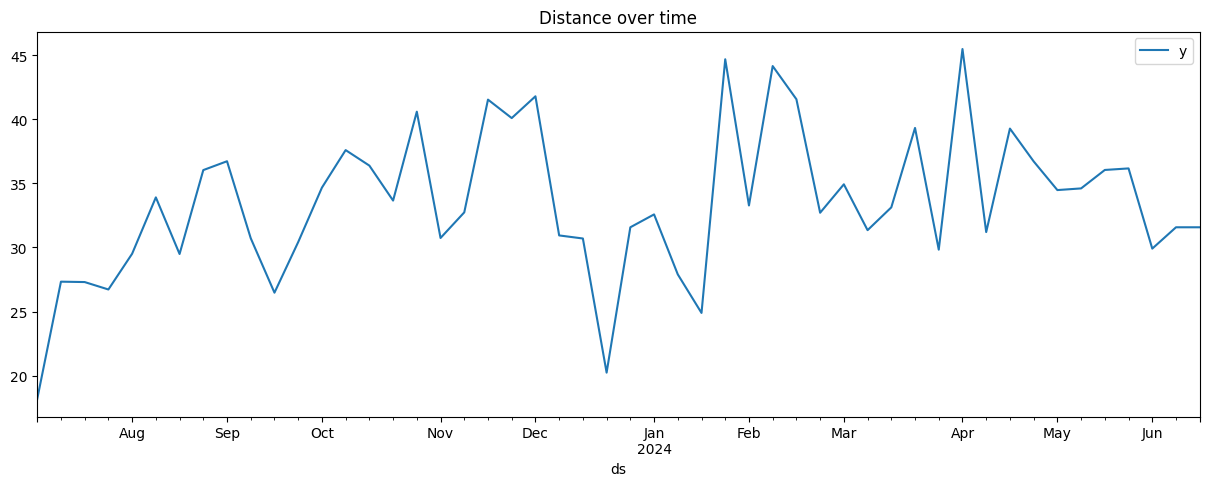

In [164]:
weekly_df.plot(figsize=(15,5), x='ds', title='Distance over time');

### **Export weekly data**

In [90]:
# Export weekly data to compare with Google sheets and Excel predictions
weekly_df.to_csv(path + 'weekly_df.csv', index=False)

## Prophet Model

In [165]:
# Set the size of prediction in weeks
size_pred = 6

# Split data, remember we are working with a time serie data
train_df = weekly_df.iloc[:-size_pred]
test_df = weekly_df.iloc[-size_pred:]

In [166]:
# Create model and fit
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pswsv1h/osiwdnxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pswsv1h/6m8o5bn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83548', 'data', 'file=/tmp/tmp4pswsv1h/osiwdnxf.json', 'init=/tmp/tmp4pswsv1h/6m8o5bn4.json', 'output', 'file=/tmp/tmp4pswsv1h/prophet_modelyo4u06gf/prophet_model-20241128093823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:23 - cmdstanpy - INFO - Chai

In [169]:
future = m.make_future_dataframe(periods=size_pred, freq='W')
future.tail()

,ds
45,2024-05-19
46,2024-05-26
47,2024-06-02
48,2024-06-09
49,2024-06-16


In [170]:
forecast = m.predict(future)

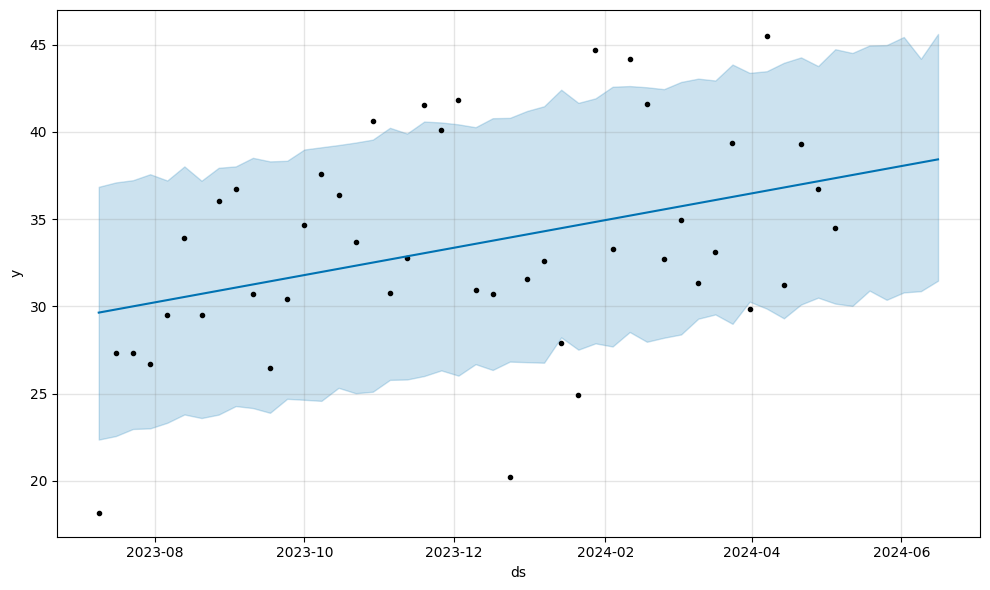

In [171]:
m.plot(forecast);

In [172]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
45,2024-05-19,30.899719,44.945830,37.702928
46,2024-05-26,30.371780,44.967753,37.882116
47,2024-06-02,30.795281,45.431707,38.061304
48,2024-06-09,30.866904,44.185042,38.240492
49,2024-06-16,31.467452,45.606599,38.419680


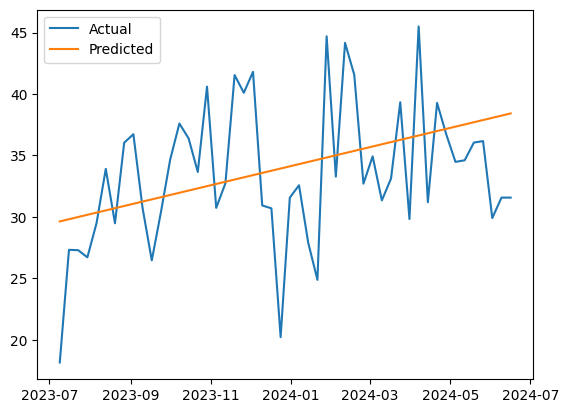

In [173]:
plt.plot(weekly_df['ds'], weekly_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()

In [185]:
mape = mean_absolute_percentage_error(weekly_df['y'], forecast['yhat']).round(4)*100
print(f"MAPE: {mape}%")

MAPE: 14.38%


### Author: Anastasia Livio